In [2]:
data_folder = "DirEOS2019"
H_filename = "TABLE_H_TP_v1"
He_filename = "TABLE_HE_TP_v1"
HHe_filename = "TABLEEOS_HHE_TP_Y0.275_v1"
Si_filename = 'EOS_Si.pkl'

In [3]:
import os
import pandas as pd
from scipy import interpolate
from scipy.integrate import solve_ivp
import numpy as np
from scipy.constants import gravitational_constant
import pickle
import scipy
import matplotlib.pyplot as plt
import time
import matplotlib.ticker as mtick

In [4]:
import logging
if not os.path.exists("log"):
    os.mkdir("log")
logging.basicConfig(filename="log/{}.log".format(time.asctime()), filemode='w', level=logging.DEBUG)

In [5]:
import sys
sys.path.insert(0, 'aneos-forsterite-2019-master')
from eostable import *

In [765]:
# read table
# interpolation
# integration (calculate rho(r), calculate m(r), calculate next T, P, m)

In [6]:
# Data Source:
# "A new equation of state for dense hydrogen-helium mixtures"
# Chabrier, Mazevet & Soubiran, ApJ 2019

def read_table(filename):
    '''
    parse the data file for H/He
    input a filename, return a panda dataframe
    '''
    logging.info("Read Table: {}".format(filename))
    
    # read file into pandas dataframe
    with open(filename, 'r') as file:
        file.readline()
        lines = file.readlines()  
        # log T [K]      log P [GPa]   log rho [g/cc] log U [MJ/kg]  log S [MJ/kg/K] 
        # dlrho/dlT_P    dlrho/dlP_T     dlS/dlT_P      dlS/dlP_T       grad_ad
        columns = ["logT", "logP", "logRho", "logU", "logS", 
                   "dlogRho/dlogT", "dlogRho/dlogP", "dlogS/dlogT", "dlogS/dlogP", "grad_ad"]
        df = pd.DataFrame(columns=columns)

        for line in lines:
            line = line.strip().split(" ")
            line = [x for x in line if x != ""]

            # ignore logT
            if len(line) == 2: 
                continue

            # read other attribute
            elif len(line) == 10: 
                line = [float(x) for x in line]
                df = df.append(dict(zip(columns, line)), ignore_index=True)

    # convert log value
    df["T"] = 10 ** df["logT"]
    df["P"] = 10 ** df["logP"]
    df["S"] = 10 ** df["logS"]
    df["rho"] = 10 ** df["logRho"]
    
    # convert units
    df["P"] = df["P"] * 1e9 # Gpa --> Pa
    df["rho"] = df["rho"] * 1000 #g/cm^3 --> kg/m^3
    
    # take only part of the columns
    df = df[["T", "P", "S", "rho"]]
    
    return df


In [7]:
def read_EOS_Si(filename):
    '''
    data from https://github.com/ststewart/aneos-forsterite-2019/blob/master
    '''
    with open(filename, 'rb') as file:
        NewEOS = pickle.load(file)
    return NewEOS
        
def S_curve(NewEOS, Smantle=0.0027):
    '''extract the T-rho-P relation with prescribed S_mantle (unit in MJ/K/kg) from the silicate data
    output:
        df (pd.DataFrame): a dataframe with interpolated T-rho-P relation
    '''
    
    # find the curve
    columns = ["T", "rho", "P", "S"]
    
    mantle_pressure = []
    mantle_temperature = []

    # loop across all densities and extract the values for the requested isentrope
    ForsteriteEOS = NewEOS
    for i in range(0,ForsteriteEOS.ND):
        ind = np.where((ForsteriteEOS.S[:,i] > 0))[0]
        interpfunction = interpolate.interp1d(ForsteriteEOS.S[ind,i],ForsteriteEOS.P[ind,i]) # MJ/K/kg, GPa
        mantle_pressure = np.append(mantle_pressure,interpfunction(Smantle)) # GPa
        interpfunction = interpolate.interp1d(ForsteriteEOS.S[ind,i],ForsteriteEOS.T[ind]) # MJ/K/kg, GPa
        mantle_temperature = np.append(mantle_temperature,interpfunction(Smantle)) # GPa

    mantle_density = ForsteriteEOS.rho # g/cm3
    
    df = pd.DataFrame({"T": mantle_temperature, 
                       "rho": mantle_density, 
                       "P": mantle_pressure,
                       "S": np.ones(ForsteriteEOS.ND) * Smantle})
    
    # unit conversion
    df["rho"] = df["rho"] * 1000 #g/cm^3 --> kg/m^3
    df["P"] = df["P"] * 1e9 # (GPa) ---> Pa
    
    return df

In [8]:
def lookup_boundary(num, vals):
    '''given a number and an array, look up the upper and lower closest values from the array
    input:
        num (number): a number
        vals (np.array): an array of shape (n,)
    '''
    sort = vals.argsort()
    idx = np.searchsorted(vals[sort], num, "right")
    lower = vals[sort][idx - 1]
    try:
        upper = vals[sort][idx]
        return lower, upper
    except: # number on the upper boundary
#         logging.debug('Point on the boundary')
        return lower, lower

    
def interpolate_curve(v1, df, target, col1):
    '''interpolate the value of a target attribute from the value of another attribute and a 1D Silicate EOS table
    input:
        v1(number): the value of "another" attibute
        df(pd.DataFrame): the Silicate EOS table
        target(str): name of the column in the Silicate EOS table for the target attribute 
        col1(str): name of the column for v1 
    output:
        S(number): the value of target attribute
        out_of_table(bool): indicate whether the interpolation is out of boundary
    '''
    # set a flag of out of boundary
    out_of_table = False
    
    # lookup the closest T in the EOS table
    T_vals = df[col1].values
    T_lower, T_upper = lookup_boundary(v1, T_vals)
    
    # lookup values
    S_lower = df[df[col1]==T_lower][target].values[0]
    S_upper = df[df[col1]==T_upper][target].values[0]
    
    # interpolate along col2, then col1
    # if reach boundary, return the boundary value
    if v1 > T_upper:
        logging.debug("warning: {} reaches upper bound".format(col1))
        out_of_table = True
        v1 = T_upper
    elif v1 < T_lower:
        logging.debug("warning: {} reaches lower bound".format(col1))
        out_of_table = True
        v1 = T_lower
    S = interpolate.interp1d([T_lower, T_upper], [S_lower, S_upper])(v1)
    
    # convert the output from 1d array to a scalar
    return np.asscalar(S), out_of_table

def interpolate_df(v1, v2, df, target="S", col1="T", col2="P"):
    '''interpolate the value of target attribute from the values of another two attributes and 2D EOS data
    input:
        v1, v2(number): the values of "another" two attributes
        df(pd.DataFrame): 2D silicate EOS data
        target(str): name of the column in the Silicate EOS data for the target attribute 
        col1, col2 (str): names of of the column for v1 and v2, respectively
    output:
        S(number): the target attribute value
        out_of_table(bool): indicate whether the interpolation is out of boundary
    '''
    # set a flag of out of boundary
    out_of_table = False
    
    # lookup the closest T and P value in the EOS table
    T_vals = df[col1].values
    T_lower, T_upper = lookup_boundary(v1, T_vals)
    P_vals1 = df[df[col1]==T_lower][col2].values
    P_vals2 = df[df[col1]==T_upper][col2].values
    P1, P2 = lookup_boundary(v2, P_vals1)
    P3, P4 = lookup_boundary(v2, P_vals2)
    
    # lookup values
    S1 = df[(df[col1]==T_lower) & (df[col2] == P1)][target].values[0]
    S2 = df[(df[col1]==T_lower) & (df[col2] == P2)][target].values[0]
    S3 = df[(df[col1]==T_upper) & (df[col2] == P3)][target].values[0]
    S4 = df[(df[col1]==T_upper) & (df[col2] == P4)][target].values[0]
    
    # interpolate along col2, then col1
    if v2 > P2: 
        logging.debug("warning: {} reaches upper bound".format(col2))
        out_of_table = True
        v2 = P2
    elif v2 < P1:
        logging.debug("warning: {} reaches lower bound".format(col2))
        out_of_table = True
        v2 = P1
    if v2 > P4: 
        logging.debug("warning: {} reaches upper bound".format(col2))
        out_of_table = True
        v2 = P4
    elif v2 < P3:
        logging.debug("warning: {} reaches lower bound".format(col2))
        out_of_table = True
        v2 = P3
    S_lower = interpolate.interp1d([P1, P2], [S1, S2])(v2)
    S_upper = interpolate.interp1d([P3, P4], [S3, S4])(v2)
    
    if v1 > T_upper: 
        logging.debug("warning: {} reaches upper bound".format(col1))
        out_of_table = True
        v1 = T_upper
    elif v1 < T_lower:
        logging.debug("warning: {} reaches lower bound".format(col1))
        out_of_table = True
        v1 = T_lower
    S = interpolate.interp1d([T_lower, T_upper], [S_lower, S_upper])(v1)
    
    # convert the output from 1d array to a scalar
    return np.asscalar(S), out_of_table


def interpolate_S(T, P, NewEOS):
    '''we want to get S value of a given (T, P) combination
    input:
        T(number): temperature
        P(number): pressure
        NewEOS(extEOStable): EOS of Si is an object with T(n), rho(m), P(n*m) and S(n*m), 
        data from https://github.com/ststewart/aneos-forsterite-2019/blob/master
    '''
    # find the T value that is closest to T_given
    T_lower, T_upper = lookup_boundary(T, NewEOS.T)
    T_lower_idx = np.where(NewEOS.T == T_lower)[0][0]
    T_upper_idx = np.where(NewEOS.T == T_upper)[0][0]
    
    # convert pressure unit from Pa to GPa
    P = P / 1e9
    
    # for T_lower and T_upper, find the points which P is closest to P_given, add them to a list
    points = []
    for i in [T_lower_idx, T_upper_idx]:
        P_vector = NewEOS.P[i,:]
        S_vector = NewEOS.S[i,:]
        sort = P_vector.argsort()
        j = np.searchsorted(P_vector[sort], P, "right") - 1
        if j == NewEOS.ND - 1: 
            raise Exception('Error occurred at initialization: P too large, out of range')
        points.append([NewEOS.T[i], NewEOS.rho[sort][j], P_vector[sort][j], S_vector[sort][j]])
        points.append([NewEOS.T[i], NewEOS.rho[sort][j+1], P_vector[sort][j+1], S_vector[sort][j+1]])
    
    # interpolate S and rho
    S_lower = interpolate.interp1d([points[0][2], points[1][2]], [points[0][3], points[1][3]])(P)
    S_upper = interpolate.interp1d([points[2][2], points[3][2]], [points[2][3], points[3][3]])(P)
    S = interpolate.interp1d([T_lower, T_upper], [S_lower, S_upper])(T)
#     rho_lower = interpolate.interp1d([points[0][2], points[1][2]], [points[0][1], points[1][1]])(P)
#     rho_upper = interpolate.interp1d([points[2][2], points[3][2]], [points[2][1], points[3][1]])(P)
#     rho = interpolate.interp1d([T_lower, T_upper], [rho_lower, rho_upper])(T)
    
    # S unit: kJ/K/kg
    
    
    return np.asscalar(S)
    

In [74]:
# integration
def calc_rho(rho_Si, rho_H, rho_He, f, f_He):
    '''calculate the density of silicate, hydrogen and helium mixture, using the linear mixing approximation'''
    if f > 0 and f_He > 0:
        if f_He == 0.275:    # cosmogonic He mass fraction
            return 1.0 / ( (1-f)/rho_Si + f/rho_H )
        else:                # Pure He
            return 1.0 / ( (1-f)/rho_Si + f*(1-f_He)/rho_H + f*f_He/rho_He )
    elif f > 0:              # Pure H
        return 1.0 / ( (1-f)/rho_Si + f/rho_H )
    else:                    # No dissolved gas
        return rho_Si

def calc_delta_r(delta_M, rho, R):
    '''calculate the thickness of the last layer in the mantle'''
    return delta_M / (4 * np.pi * rho * R ** 2)
        
def calc_rho_Fe(P, rho_Fe_0=8300.00, c=0.00349, n=0.528):
    '''calculate the density of iron core
    formula from Table 3: https://arxiv.org/pdf/0707.2895.pdf'''
    return rho_Fe_0 + c * P ** n

def calc_M_Fe(rho_Fe, R):
    '''calculate the mass of the last layer (actually a sphere) of iron core'''
    return (4/3) * np.pi * R ** 3 * rho_Fe

class value_recorder():
    '''value recorder during the integration'''
    def __init__(self):
        self.r = []
        self.M = []
        self.P = []
        self.rho = []
        self.current_T = None
        self.T = []
        self.out_of_boundary = False
        self.out_of_table = False
        
    def set_T(self, T):
        self.current_T = T
        
    def reset_all(self):
        self.r = []
        self.M = []
        self.P = []
        self.rho = []
        self.current_T = None
        self.T = []
        self.out_of_boundary = False
        self.out_of_table = False
    
    def flag_out_of_table(self, out_of_table):
        if out_of_table:
            self.out_of_table = True
        
    def sort(self):
        # for the debug use, sort the values according to r
        argsort = np.array(self.r).argsort()
        self.M = list(np.array(self.M)[argsort])
        self.P = list(np.array(self.P)[argsort])
        self.rho = list(np.array(self.rho)[argsort])
        self.T = list(np.array(self.T)[argsort])
        self.current_T = self.T[-1]
        
class guess_history():
    '''record the history of R_guess'''
    def __init__(self):
        self.r = []
        self.m_error_pair = [] # when R_guess is too small, we will have m error
        
            
def func_mantle(r, y, EOS_Si, EOS_H, EOS_He, EOS_HHe, M_boundary, S_Si, f, f_He, ValueRecorder):
    '''
    calculate dMdr and dPdr at one layer in the mantle
    input: 
        r (num): radius
        y ([M, P]): a list which contains mass, pressure
        EOS_Si, EOS_H, EOS_He (pd.DataFrame): the EOS table of materials
        M_boundary (number): the mass boundary to switch from mantle to iron core
        S_Si: the constant entropy of silicate
        f: dissolved gas mass fraction
        f_He: He mass fraction
        ValueRecorder (object): a small object to record values in the integration process
    output:
        (dM_dr, dP_dr): a list which contains the differential values
    '''
    # get P, T, M
    M, P = y[0], y[1]
    T = ValueRecorder.current_T
    G = gravitational_constant
    
    # record values
    ValueRecorder.r.append(r)
    ValueRecorder.M.append(M)
    ValueRecorder.P.append(P)
    ValueRecorder.T.append(T)
        
#     print("r, (M, P): ", r, y)
        
    # lookup table to acquire the density of silicate
    rho_Si, out_of_table = interpolate_curve(P, EOS_Si, target="rho", col1="P")
    ValueRecorder.flag_out_of_table(out_of_table)
        
    # initialize the density of H, He
    rho_H, rho_He = 0, 0
    
    if f_He == 0.275:     # cosmogenic composition, directly apply the density of mixture to rho_H
        rho_H, out_of_table = interpolate_df(T, P, EOS_HHe, target="rho")
        ValueRecorder.flag_out_of_table(out_of_table)
        rho_He = 0
    else:    
        if f > 0:         # pure H
            rho_H, out_of_table = interpolate_df(T, P, EOS_H, target="rho") 
            ValueRecorder.flag_out_of_table(out_of_table)
        if f_He > 0:      # pure He
            rho_He, out_of_table = interpolate_df(T, P, EOS_He, target="rho")
            ValueRecorder.flag_out_of_table(out_of_table)
    
    
    # calculate rho
    rho = calc_rho(rho_Si, rho_H, rho_He, f, f_He)  
    
    dM_dr = 4 * np.pi * r **2 * rho
    dP_dr = - G * M * rho / r ** 2
    
    # record the values
    ValueRecorder.current_T, out_of_table = interpolate_curve(P, EOS_Si, target="T", col1="P")
    ValueRecorder.flag_out_of_table(out_of_table)
    ValueRecorder.rho.append(rho)
    
    return (dM_dr, dP_dr)

def func_metal(r, y, M_boundary, ValueRecorder):
    '''
    input: 
        r (num): radius
        y ([M, P]): a list which contains mass, pressure
        EOS_Si, EOS_H, EOS_He (pd.DataFrame): the EOS table of the elements
        M_boundary (number): the mass boundary of silicate and metal
        S_Si: the constant entropy of silicate
        f: dissolved gas mass fraction
        f_He: He mass fraction
        ValueRecorder (object): a small object to record values in the integration process
    output:
        (dM_dr, dP_dr): a list which contains the partial differential values
    '''
    # get P, T, M
    M, P = y[0], y[1]
    G = gravitational_constant
    
    # record values
    ValueRecorder.r.append(r)
    ValueRecorder.M.append(M)
    ValueRecorder.P.append(P)
    
#     print("r, (M, P): ", r, y)
        
    # lookup table
    rho = calc_rho_Fe(P)  
    
    dM_dr = 4 * np.pi * r **2 * rho
    dP_dr = - G * M * rho / r ** 2
    
    # record the values
    ValueRecorder.rho.append(rho)
    
    return (dM_dr, dP_dr)



def integrate(M_core, f, f_He, f_M, R_guess, 
              T_EC, P_EC, 
              dr_coeff,
              EOS_H, EOS_He, EOS_Si_obj, 
              ValueRecorder, MetalValueRecorder,
              R_guess_history,
              R_guess_max = None, R_guess_min = None, 
              uniform=True, T_jump=False):
    '''
    input:
        M_core: mass of core
        f: dissolved gas mass fraction
        f_He: He mass fraction
        f_M: metal mass fraction
        R_guess: initial guess of radius
        T_EC, P_EC: envelope-core boundary condition
        dr_coeff: a coeffcient to set the maxium possible dr for the RK4 integrator
        uniform: uniform dissolved gas assumption
        T_jump: whether there is a temperature jump between the magma ocean and iron core
        EOS_H, EOS_He: input tables of H and He EOS
        ValueRecorder, MetalValueRecorder: value recorder of the integration values (for debugging purpose)
        EOS_Si_obj: input object of silicate EOS
    '''
    # append to guess history 
    R_guess_history.r.append(R_guess)
    
    # define the range of R_guess to from 0.01*R_guess to 100*R_guess
    if not R_guess_max:
        R_guess_max = R_guess * 1e2
    if not R_guess_min:
        R_guess_min = R_guess * 1e-2
    
    # reset the recorder
    ValueRecorder.reset_all()
    MetalValueRecorder.reset_all()
    
    # set the max possible dr for the RK4 integrator
    dr_max = dr_coeff * R_guess
    
    # calculate the total mass of each component
    M_silicate = (1-f_M) * M_core
    M_metal = f_M * M_core
    M_mantle = M_silicate / (1-f)
    M_total = M_mantle + M_metal
    
    # set the gravitational constant
    G = gravitational_constant
    
    # stop integration when r is smaller than 5 * dr
    r_lim = 5
    
    
    # for silicate, get S from T and P at the envelope-mantle boundary
    S_Si = interpolate_S(T_EC, P_EC, EOS_Si_obj)
    # then interpolate the EOS_Si with a fixed entropy S_Si
    EOS_Si = S_curve(EOS_Si_obj, S_Si)
    
    # interpolate other initial conditions
    rho_Si, out_of_table = interpolate_curve(P_EC, EOS_Si, target="rho", col1="P")
    ValueRecorder.flag_out_of_table(out_of_table)
        
    rho_H, out_of_table = interpolate_df(T_EC, P_EC, EOS_H, target="rho")
    ValueRecorder.flag_out_of_table(out_of_table)
        
    rho_He, out_of_table = interpolate_df(T_EC, P_EC, EOS_He, target="rho")
    ValueRecorder.flag_out_of_table(out_of_table)
    
    # calculate the density of mixture at the envelope-mantle boundary
    rho = calc_rho(rho_Si, rho_H, rho_He, f, f_He)
    
#     print("initial condition (rho, M_total, S_Si): ", rho, M_total, S_Si)
    
    while True:
        # integration over the mantle
        ValueRecorder.set_T(T_EC)
        
        try: 
            def reach_boundary(r, y, *args):
                return y[0] - M_metal # when mass reaches the iron core boundary, stop integration
            reach_boundary.terminal = True

            solve_ivp(func_mantle, 
                    t_span=(R_guess, r_lim * abs(dr_max)), # integrate from R_guess to 0
                    y0=(M_total, P_EC), # initial y
                    method='RK45', # Explicit Runge-Kutta method of order 5(4)
                    max_step=abs(dr_max), # maximum stepsize is dr
                    events = [reach_boundary],
                    args=[EOS_Si, EOS_H, EOS_He, EOS_HHe, M_metal, S_Si, f, f_He, ValueRecorder] # pass in additional args
                    )
        except:
            raise Exception("Integration fails for mantle.")

        # process the result
        boundary = len(ValueRecorder.M) - 1 # get the index of t where the M first smaller than M_metal 
        # ???? may cause some problems
        logging.info("boundary (r, M, P, T, rho) before adjustment: {}, {}, {}, {}, {}".format(ValueRecorder.r[-1], \
            ValueRecorder.M[-1], ValueRecorder.P[-1], ValueRecorder.T[-1], ValueRecorder.rho[-1]))
        
        # when R_guess is too large, M could be below zero
        if ValueRecorder.M[-1] < 0:
            logging.error("R_guess is too large. Mass reaches zero at the iron core boundary.")
            R_guess_max = R_guess # decrease R_guess  
            break
            
        # ??? when R_guess is so small that the integration ends when r reaches 0
        if ValueRecorder.M[-1] > M_metal:
            logging.error("R_guess is too small. Integration ends before the iron core boundary.")
            # increase R_guess
            R_guess_min = R_guess # increase R_guess
            break

        # adjust the boundary to the accurate r value (larger than the current r)
        if ValueRecorder.M[-1] < M_metal:
            delta_M_boundary = M_metal - ValueRecorder.M[-1]
            rho_boundary = ValueRecorder.rho[-1]
            delta_r_boundary = calc_delta_r(delta_M_boundary, rho_boundary, ValueRecorder.r[-1])
            r_boundary = ValueRecorder.r[-1] + delta_r_boundary   # delta_r_boundary is a positive number
            dP_dr = - gravitational_constant * M_metal * rho_boundary / ValueRecorder.r[-1] ** 2
            P_boundary = ValueRecorder.P[-1] + dP_dr * delta_r_boundary   # by definition
            T_boundary, out_of_table = interpolate_curve(P_boundary, EOS_Si, target="T", col1="P")
            ValueRecorder.flag_out_of_table(out_of_table)
            
            rho_boundary, out_of_table = interpolate_curve(P_boundary, EOS_Si, target="rho", col1="P")
            ValueRecorder.flag_out_of_table(out_of_table)

            # save the boundary values
            ValueRecorder.r[-1] = r_boundary
            ValueRecorder.M[-1] = M_metal
            ValueRecorder.P[-1] = P_boundary
            ValueRecorder.T[-1] = T_boundary
            ValueRecorder.rho[-1] = rho_boundary

        logging.info("boundary (r, M, P, T, rho) after adjustment: {}, {}, {}, {}, {}".format(ValueRecorder.r[-1], \
            ValueRecorder.M[-1], ValueRecorder.P[-1], ValueRecorder.T[-1], ValueRecorder.rho[-1]))

        ##### add-in T_jump later

        # integration for metal core
        try:
            def reach_boundary(r, y, *args):
                return y[0] # when mass = 0
            reach_boundary.terminal = True
            
            solve_ivp(func_metal, 
                    t_span=(ValueRecorder.r[-1], r_lim * abs(dr_max)), # integrate from R_guess to 0
                    y0=(M_metal, ValueRecorder.P[-1]), # initial y
                    method='RK45', # Explicit Runge-Kutta method of order 5(4)
                    max_step=abs(dr_max), # maximum stepsize is dr
                    events = [reach_boundary],
                    args=[0, MetalValueRecorder] # pass in additional args
                    )
        except:
            logging.error("Integration for metal ends at r = {}".format(MetalValueRecorder.r[-1]))
            raise Exception("Integration fails for metal.")
        
        # post integration
        last_r = MetalValueRecorder.r[-1]
        if last_r > 0:
            # if the last radius is small enough
            # calculate the mass for the last bit of metal component
            MetalValueRecorder.M.append(MetalValueRecorder.M[-1] - \
                                        calc_M_Fe(MetalValueRecorder.rho[-1], MetalValueRecorder.r[-1]))
            MetalValueRecorder.r.append(0)
            MetalValueRecorder.P.append(MetalValueRecorder.P[-1])
            MetalValueRecorder.rho.append(MetalValueRecorder.rho[-1])

        # evaluate the error of integration result
        last_layer_M = MetalValueRecorder.M[-1]
        error_ratio = last_layer_M / M_core

        logging.info("M_error / M_core: {}".format(error_ratio))
        if abs(error_ratio) <= 0.001:
            if ValueRecorder.out_of_table:
                logging.error("Integration finishes out of table, at R={}".format(R_guess))
                raise Exception("Integration finishes out of table, at R={}".format(R_guess))
            else:
                logging.info("Integration finishes at {}".format(R_guess))
                return R_guess, ValueRecorder, MetalValueRecorder
        elif error_ratio > 0.001:
            R_guess_min = R_guess # increase R_guess
            R_guess_history.m_error_pair.append((R_guess, error_ratio))
            break
        else:
            R_guess_max = R_guess # decrease R_guess  
            R_guess_history.m_error_pair.append((R_guess, error_ratio))
            break
            
    
    # if R_guess needs to be adjusted and re-integrated
    R_guess_next = np.sqrt(R_guess_max * R_guess_min)        
    logging.info("\nnew_R_guess: {}".format(R_guess_next))
    print("new_R_guess: {}".format(R_guess_next))
    
    results = integrate(M_core, f, f_He, f_M, R_guess_next, 
              T_EC, P_EC, 
              dr_coeff,
              EOS_H, EOS_He, EOS_Si_obj, 
              ValueRecorder, MetalValueRecorder,
              R_guess_history,
              R_guess_max, R_guess_min, 
              uniform=True, T_jump=False)
    
    return results
    
    
    

# Main funtion

In [35]:
EOS_H = read_table(os.path.join(data_folder, H_filename))
EOS_He = read_table(os.path.join(data_folder, He_filename))
EOS_HHe = read_table(os.path.join(data_folder, HHe_filename))
NewEOS = read_EOS_Si(Si_filename)

In [10]:
# create result folder if it doesn't exist
figure_folder = "figures"
if not os.path.exists(figure_folder):
    os.mkdir(figure_folder)

In [ ]:
# # For the debug use, print the first 5 rows
# EOS_H.head(), EOS_He.head()

## Example 1: calculate the mass-radius relationship for Earth-like planets

In [37]:
# create result folder if it doesn't exist
result_folder = "results_f=0"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [45]:
fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]

for M_fct in fct:
    
    # save logging
    logging.info("The factor of M_Earth = {}".format(M_fct))
    print("\nThe factor of M_Earth = {}".format(M_fct))

    M_core=6e24 * M_fct
    f=0           # mass fraction of dissolved gas
    f_He=0        # mass fraction of Helium for the gas
    f_M=0.325     # mass fraction of metal for the core

    R_guess = 6371000 * 10 # initial guess for the radius (unit in m)
    dr_coeff = 0.005       # precision of each step during the integration

    T_EC=1600              # temperature at the core-envelope boundary (unit in K)
    P_EC = 1e8             # pressure at the core-envelope boundary (unit in Pa)

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()
    
    R_guess_max = None
    R_guess_min = None

    # results: R_guess, ValueRecorder, MetalValueRecorder
    R_guess_max = None 
    R_guess_min = None 
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, 
                        ValueRecorder, MetalValueRecorder, R_guess_history, R_guess_max, R_guess_min)
    
    # save results
    with open(os.path.join(result_folder, 'ValueRecorder_{}.pkl'.format(M_fct)), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'MetalValueRecorder_{}.pkl'.format(M_fct)), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'R_guess_history_{}.pkl'.format(M_fct)), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)




The factor of M_Earth = 1


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


new_R_guess: 6371000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 6604388.387076573
new_R_guess: 6486644.619066536
new_R_guess: 6545251.744070336
new_R_guess: 6515882.289153919
new_R_guess: 6530550.506445969
new_R_guess: 6523212.274897732


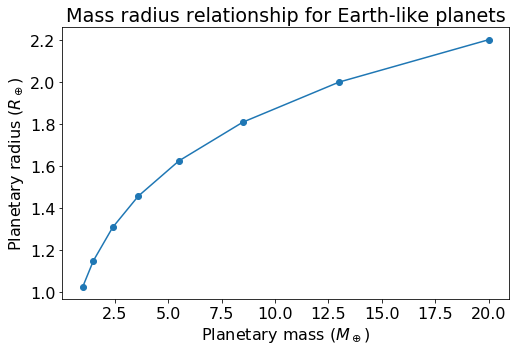

In [21]:
# read results
fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]
final_Rs = []

for M_fct in fct:
    with open('results_f=0/R_guess_history_{}.pkl'.format(M_fct), 'rb') as file:
        R_guess_history = pickle.load(file)
    final_R = R_guess_history.r[-1]
    final_Rs.append(final_R)
    
final_Rs = np.array(final_Rs) / 6371000
    
fig = plt.figure(figsize=(8, 5))
plt.title('Mass radius relationship for Earth-like planets')
plt.ylabel(r'Planetary radius ($R_\oplus$)')
plt.xlabel(r'Planetary mass ($M_\oplus$)')
plt.plot(fct,final_Rs,'o-')
plt.show()
plt.rcParams['font.size'] = '16'
fig.savefig("figures/M_R_Earth.png")

### Check vertical thermal profiles for the $M_{core} = M_{Earth}$ case

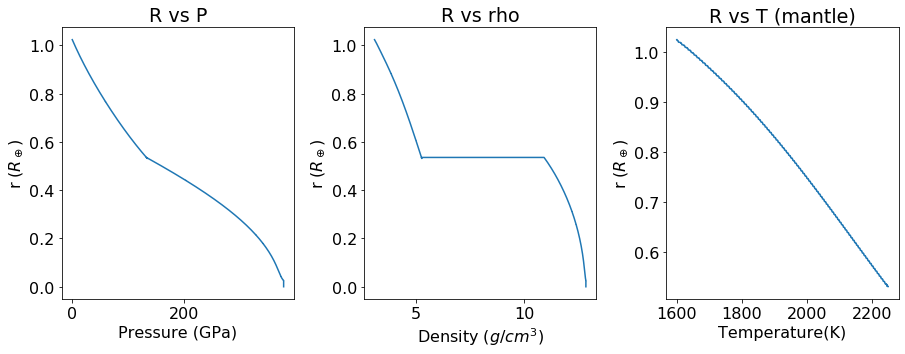

In [27]:
# plot for the case that f=0, m_fct=1
fig, axes = plt.subplots(1, 3, figsize=(15,5))
plt.subplots_adjust(wspace=0.3)

# read data
with open('results_f=0/ValueRecorder_1.pkl', 'rb') as file:
    ValueRecorder = pickle.load(file)
with open('results_f=0/MetalValueRecorder_1.pkl', 'rb') as file:
    MetalValueRecorder = pickle.load(file)

# R vs P
Rs = np.array(ValueRecorder.r + MetalValueRecorder.r)
Ps = np.array(ValueRecorder.P + MetalValueRecorder.P)
Rs /= 6371000
Ps /= 1e9 # Pa => GPa
axes[0].plot(Ps, Rs)
axes[0].set_title("R vs P")
axes[0].set_xlabel("Pressure (GPa)")
axes[0].set_ylabel(r'r ($R_\oplus$)')
# axes[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

# R vs rho
Rs = np.array(ValueRecorder.r + MetalValueRecorder.r)
rhos = np.array(ValueRecorder.rho + MetalValueRecorder.rho)
Rs /= 6371000
axes[1].plot(rhos/1e3, Rs)
axes[1].set_title("R vs rho")
axes[1].set_xlabel(r"Density ($g/cm^3$)")
axes[1].set_ylabel(r'r ($R_\oplus$)')
# axes[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

# R vs T
Rs = np.array(ValueRecorder.r)
Ts = np.array(ValueRecorder.T)
Rs /= 6371000
axes[2].plot(Ts, Rs)
axes[2].set_title("R vs T (mantle)")
axes[2].set_xlabel("Temperature(K)")
axes[2].set_ylabel(r'r ($R_\oplus$)')
# axes[2].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

fig.savefig("Earth_R_P_rho_T.png")

## Sensitivity Test 1: For the Earth's parameters, start with $R_{guess} = 0.5 \times$, $1 \times$, $10 \times R_{Earth}$

Result: the result does not depend on the choice of $R_{guess}$

In [73]:
# create result folder if it doesn't exist
result_folder = "results_sensitivity"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [78]:
result_folder = "results_sensitivity"   
R_guess_fcts = [.5, 1, 10]

for R_guess_fct in R_guess_fcts:
    # save logging
    logging.info("The factor of R_guess = {}".format(R_guess_fct))
    print("\nThe factor of R_guess = {}".format(R_guess_fct))

    M_core=6e24
    f=0
    f_He=0
    f_M=0.325

    R_guess = 6371000 * R_guess_fct
    dr_coeff = 0.005

    T_EC=1600
    P_EC = 1e8

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()
    
    R_guess_max = None
    R_guess_min = None

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, 
                        ValueRecorder, MetalValueRecorder, R_guess_history, R_guess_max, R_guess_min)
    
    # save results
    with open(os.path.join(result_folder, 'ValueRecorder_{}.pkl'.format(R_guess_fct)), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'MetalValueRecorder_{}.pkl'.format(R_guess_fct)), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'R_guess_history_{}.pkl'.format(R_guess_fct)), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)



The factor of R_guess = 0.5


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


new_R_guess: 31855000.0
new_R_guess: 10073435.486466372
new_R_guess: 5664709.060678989
new_R_guess: 7554010.939385203
new_R_guess: 6541503.971779238
new_R_guess: 6087340.701768339
new_R_guess: 6310337.818072105
new_R_guess: 6424881.314093468
new_R_guess: 6482930.40486728
new_R_guess: 6512151.333638347
new_R_guess: 6526811.151996258
new_R_guess: 6519477.12227584
new_R_guess: 6523143.106421507

The factor of R_guess = 1
new_R_guess: 63710000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 6604388.387076573
new_R_guess: 6486644.619066536
new_R_guess: 6545251.744070336
new_R_guess: 6515882.289153919
new_R_guess: 6530550.506445969
new_R_guess: 6523212.274897732

The factor of R_guess = 10
new_R_guess: 6371000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new

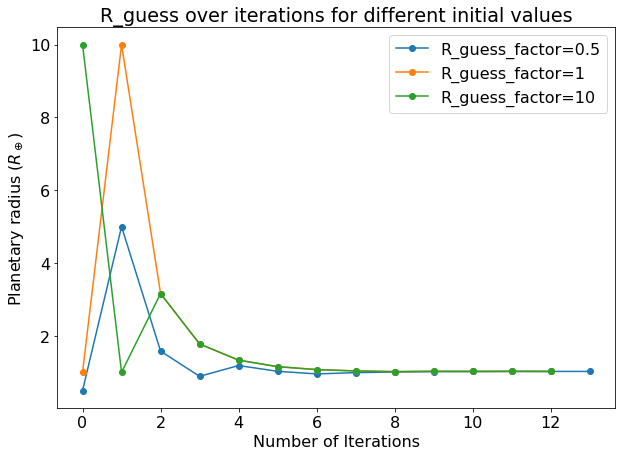

In [30]:
# read results
R_guess_fcts = [.5, 1, 10]
result_folder = "results_sensitivity"


fig = plt.figure(figsize=(10, 7))
for R_guess_fct in R_guess_fcts:
    with open(os.path.join(result_folder, 'R_guess_history_{}.pkl'.format(R_guess_fct)), 'rb') as file:
        R_guess_history = pickle.load(file)
    
    Rs = np.array(R_guess_history.r) / 6371000
    plt.plot(Rs, 'o-', label='R_guess_factor={}'.format(R_guess_fct))

plt.title('R_guess over iterations for different initial values')
plt.xlabel('Number of Iterations')
plt.ylabel(r'Planetary radius ($R_\oplus$)')
plt.legend()
plt.show()



## Sensitivity Test 2: Set the limit of max/min possble $R$, given the $R_{guess}$

Conclusion: $100 \times R_{guess}$ is okay as the starting max possible $R$ (min possible $R$ is $\frac{1}{100} \times R_{guess}$), compared to $10 \times R_{guess}$ and $5 \times R_{guess}$.

In [86]:
# create result folder if it doesn't exist
result_folder = "results_sensitivity_range"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [88]:
result_folder = "results_sensitivity_range"
R_guess_range_fcts = [5, 10, 100]    # the default is 100

for R_guess_range_fct in R_guess_range_fcts:
    # save logging
    logging.info("The factor of R_guess range = {}".format(R_guess_range_fct))
    print("\nThe factor of R_guess range = {}".format(R_guess_range_fct))

    M_core=6e24
    f=0
    f_He=0
    f_M=0.325

    R_guess = 6371000
    dr_coeff = 0.005

    T_EC=1600
    P_EC = 1e8
    
    R_guess_max = R_guess * R_guess_range_fct
    R_guess_min = R_guess / R_guess_range_fct

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, 
                        ValueRecorder, MetalValueRecorder, R_guess_history, R_guess_max, R_guess_min)
    
    # save results
    with open(os.path.join(result_folder, 'ValueRecorder_{}.pkl'.format(R_guess_range_fct)), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'MetalValueRecorder_{}.pkl'.format(R_guess_range_fct)), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'R_guess_history_{}.pkl'.format(R_guess_range_fct)), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)


The factor of R_guess range = 5


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


new_R_guess: 14245989.084651161
new_R_guess: 9526867.085160397
new_R_guess: 7790742.596155831
new_R_guess: 7045198.441499629
new_R_guess: 6699623.81561787
new_R_guess: 6533246.002509124
new_R_guess: 6451612.998466789
new_R_guess: 6492301.1969539
new_R_guess: 6512741.42294044
new_R_guess: 6522985.655878848

The factor of R_guess range = 10
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 6604388.387076573
new_R_guess: 6486644.619066536
new_R_guess: 6545251.744070336
new_R_guess: 6515882.289153919
new_R_guess: 6530550.506445969
new_R_guess: 6523212.274897732

The factor of R_guess range = 100
new_R_guess: 63710000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 6604388.387076573
new_R_guess: 6486644.619066536
new_R_guess: 6545251.744070336
new_R_g

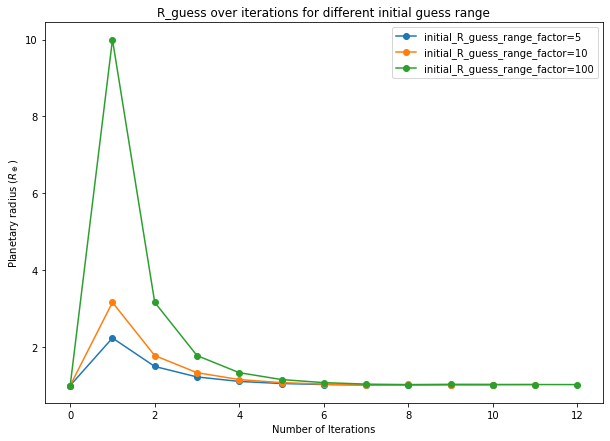

In [94]:
# read results
R_guess_range_fcts = [5, 10, 100]   
result_folder = "results_sensitivity_range"

fig = plt.figure(figsize=(10, 7))
for R_guess_range_fct in R_guess_range_fcts:
    with open(os.path.join(result_folder, 'R_guess_history_{}.pkl'.format(R_guess_range_fct)), 'rb') as file:
        R_guess_history = pickle.load(file)
    
    Rs = np.array(R_guess_history.r) / 6371000
    plt.plot(Rs, 'o-', label='initial_R_guess_range_factor={}'.format(R_guess_range_fct))

plt.title('R_guess over iterations for different initial guess range')
plt.xlabel('Number of Iterations')
plt.ylabel(r'Planetary radius ($R_\oplus$)')
plt.legend()
plt.show()

## Sensitivity test 3: Test the influence of changing precision (step size)

The precision is set by setting the max step size $dr_{max}$ for the RK4 integrator: $dr_{max}$ = $dr_{coeffs} \times R_{guess}$.

Conclusion: The final radius is not affected by the choice of precision. However, the errors of $P$ and $\rho$ in the lowest layers increase with the precision, producing a "long tail". The long tail is evident when $dr_{coeffs} \leq 0.1\%$. In the following part, we choose $dr_{coeffs} = 0.5\%$ for the default value.

In [38]:
# create result folder if it doesn't exist
result_folder = "results_sensitivity_drmax"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [39]:
result_folder = "results_sensitivity_drmax"
dr_coeffs = [0.001, 0.005, 0.01]    # the default is 0.005

for dr_coeff in dr_coeffs:
    # save logging
    logging.info("dr_coeff = {}".format(dr_coeff))
    print("\ndr_coeff = {}".format(dr_coeff))

    M_core=6e24
    f=0
    f_He=0
    f_M=0.325

    R_guess = 6371000
    dr_coeff = dr_coeff

    T_EC=1600
    P_EC = 1e8
    
    R_guess_max = None
    R_guess_min = None

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, 
                        ValueRecorder, MetalValueRecorder, R_guess_history, R_guess_max, R_guess_min)
    
    # save results
    with open(os.path.join(result_folder, 'ValueRecorder_{}.pkl'.format(dr_coeff)), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'MetalValueRecorder_{}.pkl'.format(dr_coeff)), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'R_guess_history_{}.pkl'.format(dr_coeff)), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)


dr_coeff = 0.001


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


new_R_guess: 63710000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 6604388.387076573
new_R_guess: 6486644.619066536
new_R_guess: 6545251.744070336
new_R_guess: 6515882.289153919
new_R_guess: 6530550.506445969
new_R_guess: 6523212.274897732

dr_coeff = 0.005
new_R_guess: 63710000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 6604388.387076573
new_R_guess: 6486644.619066536
new_R_guess: 6545251.744070336
new_R_guess: 6515882.289153919
new_R_guess: 6530550.506445969
new_R_guess: 6523212.274897732

dr_coeff = 0.01
new_R_guess: 63710000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 6604388.387076573
new_R_guess: 648664

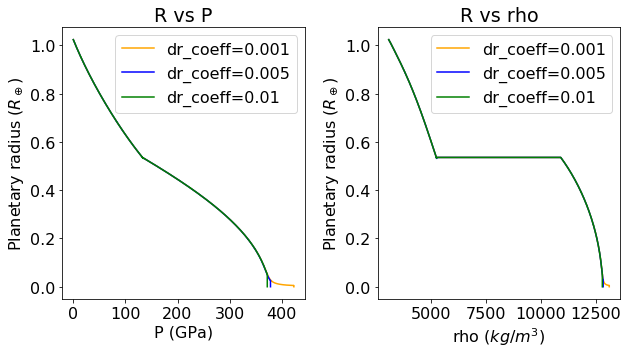

In [40]:
# read results
result_folder = "results_sensitivity_drmax"
dr_coeffs = [0.001, 0.005, 0.01]    # the default is 0.005
colors = ['orange', 'blue', 'green']

# make figures
fig, axes = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

axes[0].set_title("R vs P")
axes[0].set_xlabel("P (GPa)")
axes[0].set_ylabel(r'Planetary radius ($R_\oplus$)')

axes[1].set_title("R vs rho")
axes[1].set_xlabel(r"rho ($kg/m^3$)")
axes[1].set_ylabel(r'Planetary radius ($R_\oplus$)')

for (i, dr_coeff) in enumerate(dr_coeffs):
    color = colors[i]
    with open(os.path.join(result_folder, 'ValueRecorder_{}.pkl'.format(dr_coeff)), 'rb') as file:
        ValueRecorder = pickle.load(file)
    with open(os.path.join(result_folder, 'MetalValueRecorder_{}.pkl'.format(dr_coeff)), 'rb') as file:
        MetalValueRecorder = pickle.load(file)
    
    # R vs P
    Rs = np.array(ValueRecorder.r + MetalValueRecorder.r)
    Ps = np.array(ValueRecorder.P + MetalValueRecorder.P)
    Rs /= 6371000
    Ps /= 1e9 # Pa => GPa
    axes[0].plot(Ps, Rs, color=color, label="dr_coeff={}".format(dr_coeff))
    
    # R vs rho
    Rs = np.array(ValueRecorder.r + MetalValueRecorder.r)
    rhos = np.array(ValueRecorder.rho + MetalValueRecorder.rho)
    Rs /= 6371000
    axes[1].plot(rhos, Rs, color=color, label="dr_coeff={}".format(dr_coeff))

axes[0].legend()
axes[1].legend()
plt.show()

## Sensitivity test 4: Test the depth ($r = r_{lim} \times dr_{max}$) where the integration stops in the metal core

Conclusion: The deeper the integration stops (the smaller $r_{lim}$), the larger error we get at lowest levels. Upper and middle levels are not influenced.  

In [95]:
# create result folder if it doesn't exist
result_folder = "results_sensitivity_rlim"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [103]:
# # This part is debug-use only
# r_lim = 10
# result_folder = "results_sensitivity_rlim"

# # save logging
# logging.info("Rlim = {}".format(r_lim))
# print("\nRlim = {}".format(r_lim))

# M_core=6e24
# f=0
# f_He=0
# f_M=0.325

# R_guess = 6371000
# dr_coeff = 0.005

# T_EC=1600
# P_EC = 1e8

# # initialize value recorder
# ValueRecorder = value_recorder()
# MetalValueRecorder = value_recorder()
# R_guess_history = guess_history()

# R_guess_max = None
# R_guess_min = None

# # results: R_guess, ValueRecorder, MetalValueRecorder
# results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, 
#                     ValueRecorder, MetalValueRecorder, R_guess_history)

# # save results
# with open(os.path.join(result_folder, 'ValueRecorder_{}.pkl'.format(r_lim)), 'wb') as f:
#     pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(result_folder, 'MetalValueRecorder_{}.pkl'.format(r_lim)), 'wb') as f:
#     pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(result_folder, 'R_guess_history_{}.pkl'.format(r_lim)), 'wb') as f:
#     pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)

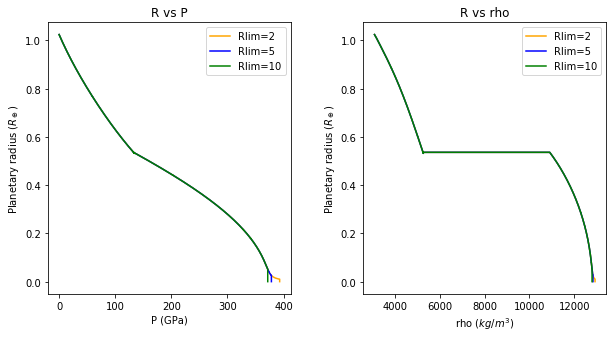

In [115]:
# read results
rlims = [2, 5, 10]   # the default is 5
colors = ['orange', 'blue', 'green']
result_folder = "results_sensitivity_rlim"

# make figures
fig, axes = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

axes[0].set_title("R vs P")
axes[0].set_xlabel("P (GPa)")
axes[0].set_ylabel(r'Planetary radius ($R_\oplus$)')

axes[1].set_title("R vs rho")
axes[1].set_xlabel(r"rho ($kg/m^3$)")
axes[1].set_ylabel(r'Planetary radius ($R_\oplus$)')

for (i, rlim) in enumerate(rlims):
    color = colors[i]
    with open(os.path.join(result_folder, 'ValueRecorder_{}.pkl'.format(rlim)), 'rb') as file:
        ValueRecorder = pickle.load(file)
    with open(os.path.join(result_folder, 'MetalValueRecorder_{}.pkl'.format(rlim)), 'rb') as file:
        MetalValueRecorder = pickle.load(file)
    
    # R vs P
    Rs = np.array(ValueRecorder.r + MetalValueRecorder.r)
    Ps = np.array(ValueRecorder.P + MetalValueRecorder.P)
    Rs /= 6371000
    Ps /= 1e9 # Pa => GPa
    axes[0].plot(Ps, Rs, color=color, label="Rlim={}".format(rlim))
    
    # R vs rho
    Rs = np.array(ValueRecorder.r + MetalValueRecorder.r)
    rhos = np.array(ValueRecorder.rho + MetalValueRecorder.rho)
    Rs /= 6371000
    axes[1].plot(rhos, Rs, color=color, label="Rlim={}".format(rlim))

axes[0].legend()
axes[1].legend()
plt.show()

## Example 2: Mass-radius relationship with varied dissolved gas fraction

In [38]:
# cosmogenic composition
f_values = [0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

# save results into a folder
result_folder = "results_fhe=0.275"

for f_value in f_values:
    
    # save logging
    logging.info("f = {}".format(f_value))

    M_core=6e24
    f=f_value
    f_He=0.275
    f_M=0.325

    R_guess = 6371000 * 10 
    dr_coeff = 0.001

    T_EC=1600
    P_EC = 1e8

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, ValueRecorder, MetalValueRecorder, R_guess_history)
    
    # save results
    with open('results_fhe=0.275/ValueRecorder_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open('results_fhe=0.275/MetalValueRecorder_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open('results_fhe=0.275/R_guess_history_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:140: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


In [50]:
# pure Helium case
f_values = [0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

# save results into a folder
f_He=0
result_folder = "results_fhe={}".format(f_He)

for f_value in f_values:
    
    # save logging
    logging.info("f = {}".format(f_value))

    M_core=6e24
    f=f_value
    f_M=0.325

    R_guess = 6371000 * 10 
    dr_coeff = 0.001

    T_EC=1600
    P_EC = 1e8

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, ValueRecorder, MetalValueRecorder, R_guess_history)
    
    # save results
    with open('results_fhe=0/ValueRecorder_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open('results_fhe=0/MetalValueRecorder_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open('results_fhe=0/R_guess_history_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:140: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


In [51]:
# pure Hydrogen case
f_values = [0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

# save results into a folder
f_He=1
result_folder = "results_fhe={}".format(f_He)

for f_value in f_values:
    
    # save logging
    logging.info("f = {}".format(f_value))

    M_core=6e24
    f=f_value
    f_M=0.325

    R_guess = 6371000 * 10 
    dr_coeff = 0.001

    T_EC=1600
    P_EC = 1e8

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, ValueRecorder, MetalValueRecorder, R_guess_history)
    
    # save results
    with open('results_fhe=1/ValueRecorder_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open('results_fhe=1/MetalValueRecorder_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open('results_fhe=1/R_guess_history_f={}.pkl'.format(f_value), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:140: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


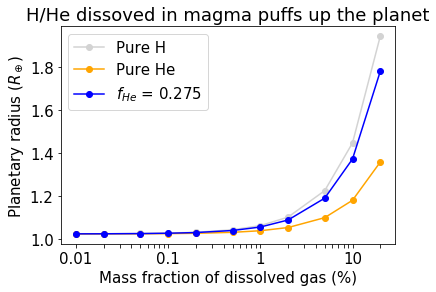

In [47]:
# plotting M-R relations with different dissolved gas compositions
# read results
f_values = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

x = np.log10(f_values)
y = []

for fhe in [0, 1, 0.275]:
    final_Rs = []
    for f_value in f_values:
        with open('results_fhe={}/R_guess_history_f={}.pkl'.format(fhe, f_value), 'rb') as file:
            R_guess_history = pickle.load(file)
        final_Rs.append(R_guess_history.r[-1] / 6371000)
    y.append(final_Rs)
        

# plot log10 because the x scale is uneven
# fig = plt.figure(figsize=(9, 4))
plt.plot(x, y[0], 'o-', color='lightgrey', label='Pure H')
plt.plot(x, y[1], 'o-', color='orange', label='Pure He')
plt.plot(x, y[2], 'o-', color='blue', label='$f_{He}$ = 0.275')
plt.legend()
plt.title('H/He dissoved in magma puffs up the planet')
plt.xlabel('Mass fraction of dissolved gas (%)')
plt.ylabel(r'Planetary radius ($R_\oplus$)')
plt.xticks(np.log10([round(0.0001*x,4) for x in range(1,10)]
                    +[round(0.001*x,4) for x in range(1,10)]
                    +[round(0.01*x,4) for x in range(1,10)]+[0.1,0.2]),
           labels=['0.01','','','','','','','','',
                   '0.1','','','','','','','','',
                   '1','','','','','','','','','10',''])
plt.rcParams['font.size'] = '5'
plt.show()


## Combining factors of f and M

In [48]:
# create result folder if it doesn't exist
result_folder = "results_combined_fM"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [80]:
from multiprocessing import Pool

def f(x):
    f_value, M_fct = x[0], x[1]
    # save logging
    logging.info("f = {}, M = {}".format(f_value, M_fct))
    print("f = {}, M = {}".format(f_value, M_fct))

    if os.path.exists(os.path.join(result_folder, 'ValueRecorder_f={}_m={}.pkl'.format(f_value, M_fct))):
        return

    M_core=6e24 * M_fct
    f=f_value
    f_He=0.275
    f_M=0.325

    R_guess = 6371000 * 10 
    dr_coeff = 0.005

    T_EC=1600
    P_EC = 1e8

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, ValueRecorder, MetalValueRecorder, R_guess_history)

    # save results

    # save results
    with open(os.path.join(result_folder, 'ValueRecorder_f={}_m={}.pkl'.format(f_value, M_fct)), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'MetalValueRecorder_f={}_m={}.pkl'.format(f_value, M_fct)), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'R_guess_history_f={}_m={}.pkl'.format(f_value, M_fct)), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)

if __name__ == '__main__':
    # cosmogenic composition
    f_values = [0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
    fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]

    # save results into a folder
    result_folder = "results_combined_fM"

    tups = []
    for f_value in f_values:
        for M_fct in fct:
            tups.append((f_value, M_fct))

    with Pool(5) as p:
        print(p.map(f, tups))
        

f = 0, M = 8.5
f = 0.0001, M = 20
f = 0, M = 1
f = 0.0001, M = 2.4
f = 0.0002, M = 5.5
f = 0.0002, M = 1
f = 0, M = 13
f = 0, M = 1.5
f = 0.0001, M = 3.6


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


f = 0.0002, M = 1.5
f = 0, M = 20
f = 0, M = 2.4
f = 0.0001, M = 5.5
f = 0.0002, M = 2.4
f = 0.0001, M = 1
f = 0, M = 3.6
f = 0.0001, M = 8.5
f = 0.0001, M = 1.5
f = 0.0002, M = 3.6
f = 0, M = 5.5
f = 0.0001, M = 13
f = 0.0005, M = 1.5
f = 0.0005, M = 13
f = 0.001, M = 3.6


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipyke

new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 8495865.044312537
new_R_guess: 8495865.044312537
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6846326.474235114
new_R_guess: 15108021.878770405
new_R_guess: 9810871.897525024
new_R_guess: 9810871.897525024
new_R_guess: 13083007.943558477
new_R_guess: 9810871.897525024
new_R_guess: 9129723.08497969
new_R_guess: 9129723.08497969
new_R_guess: 7097127.462026886
new_R_guess: 12174681.403536677
new_R_guess: 9464171.57740775
new_R_guess: 10542839.743738009
new_R_guess: 9464171.57740775
new_R_g

new_R_guess: 11744447.884638444
new_R_guess: 14027524.71582011
new_R_guess: 7906014.4737492055
new_R_guess: 13562276.837304689
new_R_guess: 11535066.566325793
new_R_guess: 9326849.067895055
f = 0.0005, M = 1
new_R_guess: 6371000.0
new_R_guess: 8195634.936193464
f = 0.002, M = 8.5
new_R_guess: 13808455.512320386
new_R_guess: 9321607.410575246
new_R_guess: 6371000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8344399.820859057
f = 0.002, M = 5.5
new_R_guess: 13933215.527065333
new_R_guess: 6371000.0
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 8419791.847415484
new_R_guess: 20146870.972932745
new_R_guess: 13996017.60468175
new_R_guess: 11329418.121357977
new_R_guess: 6846326.474235114
new_R_guess: 8382011.07033654
new_R_guess: 20146870.972932745
new_R_guess: 6604388.387076573
new_R_guess: 14027524.71582011
new_R_guess: 11329418.121357977
new_R_guess: 15108021.878770405
new_R_guess: 13083007.943558477
new_R_guess: 8363184.3022

new_R_guess: 6371000.0
new_R_guess: 8543759.43149933
new_R_guess: 13083007.943558477
new_R_guess: 6624839.765981426
new_R_guess: 12174681.403536677
f = 0.01, M = 3.6
new_R_guess: 6371000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 11744447.884638444
f = 0.005, M = 1.5
new_R_guess: 20146870.972932745
new_R_guess: 6371000.0
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 11535066.566325793
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 20146870.972932745
new_R_guess: 11639286.410001628
new_R_guess: 8495865.044312537
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 15108021.878770405
new_R_guess: 9810871.897525024
f = 0.005, M = 13
new_R_guess: 7357116.024456538
new_R_guess: 6371000.0
new_R_guess: 13083007.943558477
new_R_guess: 9810871.897525024
new_R_guess: 7906014.4737492055
new_R_guess: 10542839.743738009
new_R_guess: 14059102.75413792
new_R_guess: 9129723.08497969
n

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


new_R_guess: 6371000.0
new_R_guess: 14059102.75413792
new_R_guess: 15108021.878770405
new_R_guess: 15108021.878770405
new_R_guess: 14059102.75413792
new_R_guess: 13562276.837304689
new_R_guess: 13083007.943558477
new_R_guess: 13083007.943558477
new_R_guess: 20146870.972932745
new_R_guess: 12174681.403536677
new_R_guess: 13562276.837304689
new_R_guess: 11329418.121357977
new_R_guess: 13808455.512320386
new_R_guess: 11744447.884638444
new_R_guess: 8495865.044312537
new_R_guess: 14059102.75413792
new_R_guess: 13320487.062986713
new_R_guess: 13933215.527065333
new_R_guess: 11535066.566325793
new_R_guess: 14574128.859228497
new_R_guess: 13201213.50698954
new_R_guess: 9810871.897525024
new_R_guess: 13996017.60468175
new_R_guess: 11431779.922111955
new_R_guess: 14314299.674938357
new_R_guess: 9129723.08497969
new_R_guess: 13260716.184866473
new_R_guess: 14027524.71582011
new_R_guess: 11483307.118297763
new_R_guess: 14443630.01437534
new_R_guess: 11509157.745514113
new_R_guess: 14043304.859110

new_R_guess: 12395672.8323812
new_R_guess: 19654654.66377777
f = 0.2, M = 13
new_R_guess: 12284680.19594797
new_R_guess: 6371000.0
new_R_guess: 19676764.998509392
new_R_guess: 12229557.12730445
new_R_guess: 20146870.972932745
new_R_guess: 19687829.491438754
new_R_guess: 12202088.416795008
new_R_guess: 11329418.121357977
new_R_guess: 12188377.206677863
new_R_guess: 15108021.878770405
new_R_guess: 12195230.884781651
new_R_guess: 12198659.168914218
new_R_guess: 17446471.489898246
new_R_guess: 12196944.906396337
new_R_guess: 18748114.839629333
new_R_guess: 18085586.831478026
new_R_guess: 18413871.37075303
new_R_guess: 18248990.91948432
new_R_guess: 18167105.159083206
new_R_guess: 18208002.006849248
new_R_guess: 18228484.94211585
new_R_guess: 18218240.59583874
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None,

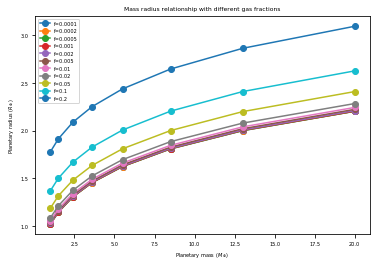

In [100]:
# plotting M-R relations with different dissolved gas compositions
# read results
f_values = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]

x = np.log10(f_values)
y = []

result_folder = result_folder = "results_combined_fM"

final_Rs = []
for f_value in f_values:
    R_forEachf = []
    for M_fct in fct:
        with open(os.path.join(result_folder, 'R_guess_history_f={}_m={}.pkl'.format(f_value, M_fct)), 'rb') as f:
            R_guess_history = pickle.load(f)
        R_forEachf.append(R_guess_history.r[-1] / 6371000)
    final_Rs.append(R_forEachf)
        

x = fct
y = final_Rs
for (i, f_value) in enumerate(f_values):
    plt.plot(x, y[i], 'o-', label='f={}'.format(f_value))
plt.legend()
plt.title('Mass radius relationship with different gas fractions')
plt.ylabel(r'Planetary radius ($R_\oplus$)')
plt.xlabel(r'Planetary mass ($M_\oplus$)')

plt.rcParams['font.size'] = '5'
plt.show()

## Combining factors of f and M

In [96]:
# create result folder if it doesn't exist
result_folder = "results_combined_fM_T=3000_P=5e9"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [97]:
from multiprocessing import Pool

def f(x):
    f_value, M_fct = x[0], x[1]
    # save logging
    logging.info("f = {}, M = {}".format(f_value, M_fct))
    print("f = {}, M = {}".format(f_value, M_fct))

    if os.path.exists(os.path.join(result_folder, 'ValueRecorder_f={}_m={}.pkl'.format(f_value, M_fct))):
        return

    M_core=6e24 * M_fct
    f=f_value
    f_He=0.275
    f_M=0.325

    R_guess = 6371000 * 10 
    dr_coeff = 0.005

    T_EC=3000
    P_EC = 5e9

    # initialize value recorder
    ValueRecorder = value_recorder()
    MetalValueRecorder = value_recorder()
    R_guess_history = guess_history()

    # results: R_guess, ValueRecorder, MetalValueRecorder
    results = integrate(M_core, f, f_He, f_M, R_guess, T_EC, P_EC, dr_coeff, EOS_H, EOS_He, NewEOS, ValueRecorder, MetalValueRecorder, R_guess_history)

    # save results

    # save results
    with open(os.path.join(result_folder, 'ValueRecorder_f={}_m={}.pkl'.format(f_value, M_fct)), 'wb') as f:
        pickle.dump(ValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'MetalValueRecorder_f={}_m={}.pkl'.format(f_value, M_fct)), 'wb') as f:
        pickle.dump(MetalValueRecorder, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(result_folder, 'R_guess_history_f={}_m={}.pkl'.format(f_value, M_fct)), 'wb') as f:
        pickle.dump(R_guess_history, f, pickle.HIGHEST_PROTOCOL)

if __name__ == '__main__':
    # cosmogenic composition
    f_values = [0, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
    fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]

    # save results into a folder
    result_folder = "results_combined_fM_T=3000_P=5e9"

    tups = []
    for f_value in f_values:
        for M_fct in fct:
            tups.append((f_value, M_fct))

    with Pool(5) as p:
        print(p.map(f, tups))

f = 0.0001, M = 2.4
f = 0, M = 1
f = 0.0001, M = 20
f = 0, M = 8.5
f = 0.0002, M = 5.5


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/opt/anaconda3/lib/python3.7/site-packages/ipyk

new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 6371000.0
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 7357116.024456538
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 8495865.044312537
new_R_guess: 6846326.474235114
new_R_guess: 8495865.044312537
new_R_guess: 15108021.878770405
new_R_guess: 7357116.024456538
new_R_guess: 6604388.387076573
new_R_guess: 13083007.943558477
new_R_guess: 15108021.878770405
new_R_guess: 6486644.619066536
new_R_guess: 12174681.403536677
new_R_guess: 9810871.897525024
new_R_guess: 13083007.943558477
new_R_guess: 7906014.4737492055
new_R_guess: 11744447.884638444
new_R_guess: 6545251.744070336
new_R_guess: 10542839.743738009

new_R_guess: 7626628.729288296
new_R_guess: 9384702.195197947
new_R_guess: 6846326.474235114
new_R_guess: 7490660.34718085
f = 0.0001, M = 13
new_R_guess: 10495532.555465953
new_R_guess: 6371000.0
f = 0.0005, M = 1.5
new_R_guess: 6371000.0
new_R_guess: 6604388.387076573
new_R_guess: 7423587.897641235
new_R_guess: 10471958.623686787
new_R_guess: 6724269.40719758
new_R_guess: 7390277.226241107
new_R_guess: 10460191.521193923
new_R_guess: 20146870.972932745
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 11329418.121357977
new_R_guess: 6664059.332304145
new_R_guess: 8495865.044312537
new_R_guess: 7406913.836203113
f = 0.0005, M = 13
new_R_guess: 6371000.0
new_R_guess: 7357116.024456538
new_R_guess: 6634156.77121507
new_R_guess: 7398590.855049496
new_R_guess: 15108021.878770405
new_R_guess: 7906014.4737492055
new_R_guess: 6619255.844719875
new_R_guess: 7402751.175925875
new_R_guess: 13083007.943558477
new_R_guess: 20146870.972932745
new_R_guess: 7626628.7292882

new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 20146870.972932745
new_R_guess: 12849762.628186936
new_R_guess: 8495865.044312537
new_R_guess: 11329418.121357977
new_R_guess: 7357116.024456538
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 12965860.80973456
new_R_guess: 20146870.972932745
new_R_guess: 8495865.044312537
new_R_guess: 6846326.474235114
new_R_guess: 15108021.878770405
new_R_guess: 11329418.121357977
new_R_guess: 13083007.943558477
new_R_guess: 12907681.188935554
new_R_guess: 8495865.044312537
new_R_guess: 7357116.024456538
new_R_guess: 6604388.387076573
new_R_guess: 12174681.403536677
new_R_guess: 12878689.349391716
new_R_guess: 6724269.40719758
new_R_guess: 11744447.884638444
new_R_guess: 12893177.120217038
new_R_guess: 7906014.4737492055
new_R_guess: 9810871.897525024
new_R_guess: 6664059.332304145
new_R_guess: 11535066.566325793
new_R_guess: 12900427.116194244
new_R_guess: 6694096.675128191
new_R_guess: 10542839

new_R_guess: 13112459.734556785
new_R_guess: 9464171.57740775
new_R_guess: 13083007.943558477
new_R_guess: 8807093.460497178
new_R_guess: 13127210.483366445
new_R_guess: 12174681.403536677
new_R_guess: 9635962.586173981
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357977
new_R_guess: 8650079.622352127
new_R_guess: 8495865.044312537
new_R_guess: 11744447.884638444
f = 0.01, M = 20
new_R_guess: 6371000.0
new_R_guess: 9723023.940230573
new_R_guess: 8572625.565954786
new_R_guess: 7357116.024456538
new_R_guess: 11957629.834374089
new_R_guess: 9766849.150784051
new_R_guess: 8611265.511997662
new_R_guess: 7906014.4737492055
new_R_guess: 11850559.497914193
new_R_guess: 20146870.972932745
new_R_guess: 9788835.776576977
new_R_guess: 11329418.121357977
new_R_guess: 8630650.747654816
new_R_guess: 7626628.729288296
new_R_guess: 11797384.38922206
new_R_guess: 9799847.643198675
new_R_guess: 8620952.681077467
new_R_guess: 7490660.34718085
new_R_guess: 11770886.378445152
f = 0.02, M = 5.5
n

new_R_guess: 16867828.143142942
new_R_guess: 11329418.121357977
new_R_guess: 13808455.512320386
new_R_guess: 12734704.006446136
new_R_guess: 19732149.71518957
new_R_guess: 8495865.044312537
new_R_guess: 16848874.147073533
new_R_guess: 13933215.527065333
new_R_guess: 12792103.956075951
new_R_guess: 19737696.753733497
f = 0.2, M = 1
new_R_guess: 6371000.0
new_R_guess: 9810871.897525024
new_R_guess: 13870695.251105955
new_R_guess: 12820900.879059436
new_R_guess: 12835323.641242046
new_R_guess: 13839540.39337471
new_R_guess: 20146870.972932745
new_R_guess: 10542839.743738009
new_R_guess: 11329418.121357977
new_R_guess: 12828110.233195398
new_R_guess: 13823989.215594595
new_R_guess: 8495865.044312537
new_R_guess: 10170272.86565848
f = 0.05, M = 13
new_R_guess: 6371000.0
new_R_guess: 13816220.180872
new_R_guess: 10354880.828513889
new_R_guess: 9810871.897525024
f = 0.2, M = 5.5
new_R_guess: 6371000.0
new_R_guess: 10448437.641127355
new_R_guess: 20146870.972932745
new_R_guess: 11329418.121357

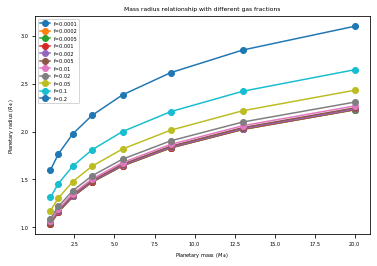

In [99]:
# plotting M-R relations with different dissolved gas compositions
# read results
f_values = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
fct = [1, 1.5, 2.4, 3.6, 5.5, 8.5, 13, 20]

x = np.log10(f_values)
y = []

result_folder = "results_combined_fM_T=3000_P=5e9"

final_Rs = []
for f_value in f_values:
    R_forEachf = []
    for M_fct in fct:
        with open(os.path.join(result_folder, 'R_guess_history_f={}_m={}.pkl'.format(f_value, M_fct)), 'rb') as f:
            R_guess_history = pickle.load(f)
        R_forEachf.append(R_guess_history.r[-1] / 6371000)
    final_Rs.append(R_forEachf)
        

x = fct
y = final_Rs
for (i, f_value) in enumerate(f_values):
    plt.plot(x, y[i], 'o-', label='f={}'.format(f_value))
plt.legend()
plt.title('Mass radius relationship with different gas fractions')
plt.ylabel(r'Planetary radius ($R_\oplus$)')
plt.xlabel(r'Planetary mass ($M_\oplus$)')

plt.rcParams['font.size'] = '5'
plt.show()

In [101]:
result_folder = "results_combined_fM_T=3000_P=5e9"

final_Rs1 = []
for f_value in f_values:
    R_forEachf = []
    for M_fct in fct:
        with open(os.path.join(result_folder, 'R_guess_history_f={}_m={}.pkl'.format(f_value, M_fct)), 'rb') as f:
            R_guess_history = pickle.load(f)
        R_forEachf.append(R_guess_history.r[-1] / 6371000)
    final_Rs1.append(R_forEachf)


In [102]:
result_folder = "results_combined_fM"

final_Rs2 = []
for f_value in f_values:
    R_forEachf = []
    for M_fct in fct:
        with open(os.path.join(result_folder, 'R_guess_history_f={}_m={}.pkl'.format(f_value, M_fct)), 'rb') as f:
            R_guess_history = pickle.load(f)
        R_forEachf.append(R_guess_history.r[-1] / 6371000)
    final_Rs2.append(R_forEachf)


In [106]:
final_Rs1[0], final_Rs2[0]

([1.0363415954173512,
  1.1619449342216097,
  1.3223240311535487,
  1.4730344051480062,
  1.6418445332277387,
  1.8289718921910687,
  2.021454928487163,
  2.2266720103519186],
 [1.0244671730288477,
  1.1489542458604773,
  1.307540284613392,
  1.456565697949483,
  1.6244014159246445,
  1.8085237597770822,
  1.9988548118735106,
  2.2017775413310483])